In [35]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [36]:
# remotes::install_github("glmmTMB/glmmTMB", subdir = "glmmTMB")


# Load Data

In [37]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2023.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2024.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2018_2023.csv" # nolint
local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegionsOnlyDF_foR.csv"

regression_df <- read.csv(local_input_path)
print(regression_df)


          date       regiao mental_health_visits total_atd periodo
1   2016-01-01          sul                38152   1491781       1
2   2016-02-01          sul                51908   2019943       2
3   2016-03-01          sul                62072   2652117       3
4   2016-04-01          sul                52677   2126983       4
5   2016-05-01          sul                55141   2382835       5
6   2016-06-01          sul                63802   2681087       6
7   2016-07-01          sul                62187   2506770       7
8   2016-08-01          sul                72404   2991575       8
9   2016-09-01          sul                64658   2694636       9
10  2016-10-01          sul                56849   2345810      10
11  2016-11-01          sul                55079   2157356      11
12  2016-12-01          sul                44722   1701881      12
13  2017-01-01          sul                52788   2078724      13
14  2017-02-01          sul                51054   2029607    

# Imports

In [38]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c("ggplot2"))
# install.packages(c(
#    # "lubridate",
#    # "ggplot2",
#    # "purrr",
#    #"glmmTMB"
# ))
library(gamlss.add)
library(gamlss)
library(glarma)
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
library(brms)
library(cmdstanr)
library(writexl)
library(glmmTMB) # For NB GLMM with autocorrelation
library(ggplot2)
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


In [39]:
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [40]:
fit_glmmTMB_nb <- function(
    data,
    response = "mental_health_visits",
    time = "periodo",
    region = "regiao",
    offset_var = "total_atd",
    pandemic_step = "Pandemia_Step",
    pandemic_trend = "Pandemia_Trend",
    postpandemia_step = "PosPandemia_Step",
    postpandemia_trend = "PosPandemia_Trend",
    nb_family = c("nbinom2", "nbinom1")) {
  # Carrega pacote
  if (!requireNamespace("glmmTMB", quietly = TRUE)) {
    stop("Instale o pacote 'glmmTMB' para continuar.")
  }

  # Seleciona família NB
  fam <- match.arg(nb_family)
  fam_fun <- switch(fam,
    nbinom2 = glmmTMB::nbinom2,
    nbinom1 = glmmTMB::nbinom1
  )

  # Constroi termo de offset (atendimentos por 1.000)
  data$offset_term <- log(data[[offset_var]] / 1000)

  # Monta fórmula do modelo
  form <- as.formula(paste0(
    response, " ~ ",
    time, " + ",
    pandemic_step, " + ",
    pandemic_trend, " + ",
    postpandemia_step, " + ",
    postpandemia_trend, " + ",
    "(1 + ", time, " | ", region, ")"
  ))

  # Ajusta o modelo
  model <- glmmTMB::glmmTMB(
    formula = form,
    data    = data,
    family  = fam_fun(),
    offset  = offset_term
  )
  result <- list(model = model, data = data)
  return(result)
}


# Model Run

In [41]:
result_list <- fit_glmmTMB_nb(regression_df, nb_family = "nbinom2")
model <- result_list$model
new_data <- result_list$data


In [42]:
print(summary(model))


 Family: nbinom2  ( log )
Formula:          
mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +  
    PosPandemia_Step + PosPandemia_Trend + (1 + periodo | regiao)
Data: data
 Offset: offset_term

     AIC      BIC   logLik deviance df.resid 
 10899.8  10942.8  -5439.9  10879.8      530 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev. Corr  
 regiao (Intercept) 2.95e-01 0.543178       
        periodo     2.63e-05 0.005129 -0.95 
Number of obs: 540, groups:  regiao, 5

Dispersion parameter for nbinom2 family ():  121 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        2.2755928  0.2431966   9.357  < 2e-16 ***
periodo            0.0147627  0.0023268   6.345 2.23e-10 ***
Pandemia_Step      0.0954826  0.0203927   4.682 2.84e-06 ***
Pandemia_Trend    -0.0164479  0.0012469 -13.191  < 2e-16 ***
PosPandemia_Step  -0.2453392  0.0247209  -9.924  < 2e-16 ***
PosPandemia_Trend -0.0055108  0.0008449  -6.523 

In [43]:
#' Extrai efeitos aleatórios por região
#'
#' @param model Objeto glmmTMB ajustado
#' @return Data frame com interceptos e slopes por região
extract_random_effects <- function(model) {
  re <- glmmTMB::ranef(model)$cond
  n # re é lista: $regiao com colunas '(Intercept)' e 'periodo'
  do.call(dplyr::bind_rows, lapply(names(re), function(g) {
    df <- re[[g]]
    df$regiao <- rownames(df)
    df
  })) %>% dplyr::rename(
    intercept_re = `(Intercept)`,
    slope_re     = periodo
  )
}

#' Gera predições contrafactuais (trends sem intervenções)
#'
#' @param model Objeto glmmTMB ajustado
#' @param newdata Data frame com mesma estrutura de data (inclui todas variáveis)
#' @return Vetor de predições contrafactuais (escala de resposta)
predict_counterfactual <- function(model, newdata, offset_var = "total_atd") {
  df_cf <- newdata %>%
    dplyr::mutate(
      Pandemia_Step = 0,
      Pandemia_Trend = 0,
      PosPandemia_Step = 0,
      PosPandemia_Trend = 0,
      offset_term = log(.data[[offset_var]] / 1000)
    )
  predict(model, newdata = df_cf, type = "response")
}

# Exemplo de uso:
# model <- fit_glmmTMB_nb(data = seu_df)
# ranefs <- extract_random_effects(model)
# df_new  <- seu_df  # ou construa grid de valores
# cf_pred <- predict_counterfactual(model, df_new)
# seu_df$cf_visits <- cf_pred


In [ ]:
# ranefs <- extract_random_effects(model)
# df_new <- new_data # ou construa grid de valores
# cf_pred <- predict_counterfactual(model, df_new)
## new_data$cf_visits <- cf_pred
#
# print(cf_pred)


# Diagnóstico

# Extrair

# plot panel

In [45]:
library(glmmTMB)
library(dplyr)

# Gera predições com e sem intervenção
gerar_predicoes_glmmTMB <- function(modelo, dados, offset_var = NULL) {
  dados_preditos <- dados %>%
    mutate(
      # Predição com as variáveis do modelo original (intervenções incluídas)
      predicted_segmented = predict(modelo, newdata = ., type = "response")
    )

  # Criar nova base com variáveis de intervenção zeradas (contrafactual)
  dados_contrafactual <- dados %>%
    mutate(
      Pandemia_Step = 0,
      Pandemia_Trend = 0,
      PosPandemia_Step = 0,
      PosPandemia_Trend = 0
    )

  # Predição contrafactual
  dados_preditos$predicted_counterfactual <- predict(modelo, newdata = dados_contrafactual, type = "response")

  return(dados_preditos)
}


In [46]:
plot_its_unica <- function(data, titulo = "ITS - Brasil") {
  ggplot(data, aes(x = periodo)) +
    geom_point(aes(y = IR), size = 1.2, alpha = 0.6) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff", linewidth = 1) +
    geom_line(aes(y = predicted_counterfactual), linetype = "dashed", color = "gray30", linewidth = 1) +
    labs(
      title = titulo,
      x = "Período",
      y = "Taxa por 1000 atendimentos"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}


# def plot nacional

In [64]:
gerar_predicoes_nacionais_glmmTMB <- function(modelo, dados) {
  dados_preditos <- dados %>%
    mutate(
      predicted_segmented = predict(modelo, newdata = ., type = "response", re.form = NA)
    )

  dados_contrafactual <- dados %>%
    mutate(
      Pandemia_Step = 0,
      Pandemia_Trend = 0,
      PosPandemia_Step = 0,
      PosPandemia_Trend = 0
    )

  dados_preditos$predicted_counterfactual <- predict(modelo, newdata = dados_contrafactual, type = "response", re.form = NA)

  return(dados_preditos)
}


In [65]:
agregar_para_nacional <- function(dados_preditos) {
  dados_preditos %>%
    group_by(periodo) %>%
    summarise(
      # Somas em contagens
      mental_health_visits      = sum(mental_health_visits),
      total_atd                 = sum(total_atd),
      predicted_seg_count       = sum(predicted_segmented),
      predicted_cf_count        = sum(predicted_counterfactual)
    ) %>%
    ungroup() %>%
    # Agora calcula taxas nacionais
    mutate(
      IR_obs = mental_health_visits / total_atd * 1000,
      predicted_segmented = predicted_seg_count / total_atd * 1000,
      predicted_counterfactual = predicted_cf_count / total_atd * 1000
    )
}


In [66]:
plot_its_nacional <- function(data, titulo = "ITS - Brasil (efeitos fixos)") {
  ggplot(data, aes(x = periodo)) +
    geom_point(aes(y = IR_obs), size = 1.5, alpha = 0.7) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff", linewidth = 1.2) +
    geom_line(aes(y = predicted_counterfactual), linetype = "dashed", color = "gray30", linewidth = 1.2) +
    labs(
      title = titulo,
      x = "Período",
      y = "Taxa por 1000 atendimentos"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}


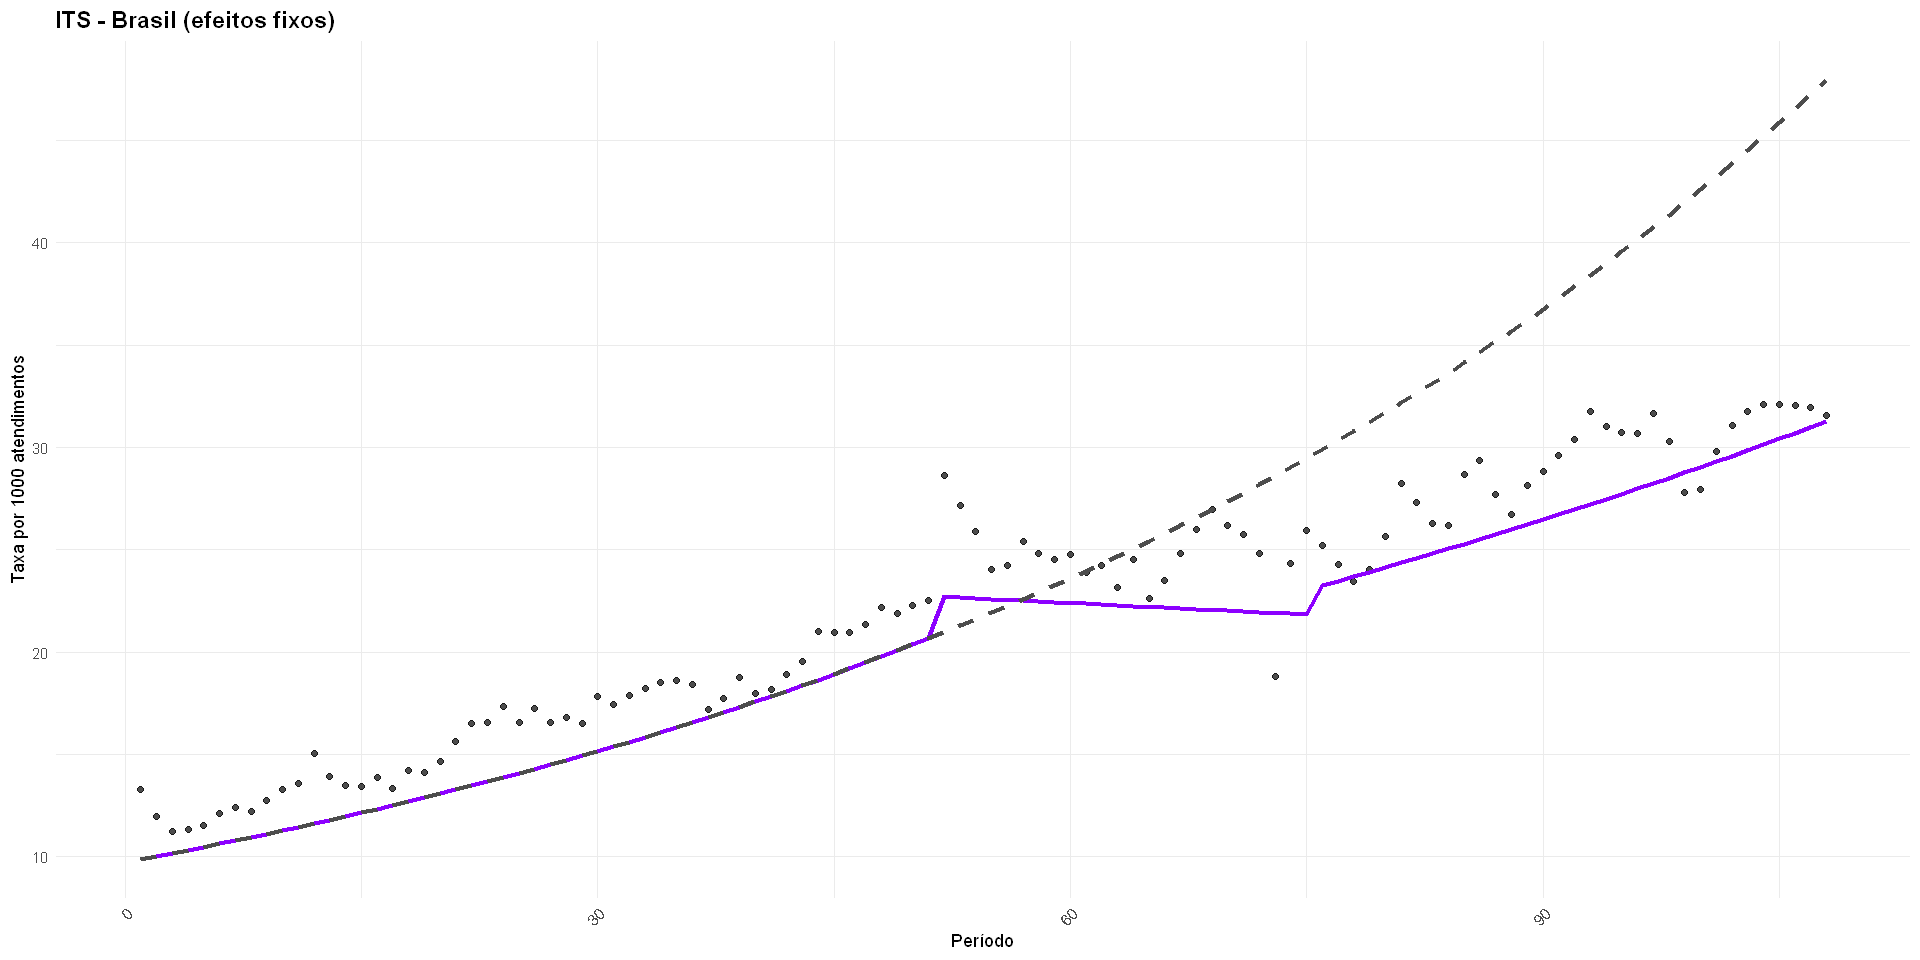

In [67]:
# regression_df_pred <- gerar_predicoes_glmmTMB(model, new_data)
#
# plot_its_unica(regression_df_pred, titulo = "ITS - Brasil")


# 1. Predição nacional com efeitos fixos
dados_preditos <- gerar_predicoes_nacionais_glmmTMB(model, new_data)

# 2. Agregação por mês
dados_nacional <- agregar_para_nacional(dados_preditos)

# 3. Plotagem
plot_its_nacional(dados_nacional)
